In [2]:
import pandas as pd
from dateutil import parser
import numpy as np
import math
import statistics as st
from scipy import stats as stat
import matplotlib
import seaborn as sns
!pip install torch

     |████████████████████████████████| 133.8 MB 350 kB/s eta 0:00:01 | 49.5 MB 248 kB/s eta 0:05:40     |████████████▊                   | 53.4 MB 1.1 MB/s eta 0:01:16     |███████████████████▊            | 82.5 MB 1.3 MB/s eta 0:00:40     |██████████████████████▋         | 94.6 MB 2.0 MB/s eta 0:00:20


In [249]:
df = pd.read_excel('Lista Incendios_2015.xlsx')
df

,Ano,Codigo SGIF,Codigo_ANPC,Tipo,Distrito,Concelho,Freguesia,Local,INE,x,...,Falso Alarme,Fogacho,Incendio,Agricola,Perimetro,APS,Causa,TipoCausa,Região PROF,UGF
0,2015,DM315252,2015160007544,Florestal,Viana do Castelo,Ponte de Lima,Serdedelo,VALE DE TROVELA (SERDEDELO),160746,167814,...,0,0,1,0,NaN,NaN,122.0,Negligente,Entre Douro e Minho,Alto Minho
1,2015,DM215305,2015130043758,Florestal,Porto,Marco de Canaveses,Vila Boa de Quires,LUGAR DO FOFO,130731,193731,...,0,0,1,0,NaN,NaN,122.0,Negligente,Entre Douro e Minho,Tâmega
2,2015,DM415293,2015030021973,Florestal,Braga,Vila Verde,Lage,RUA PROF ABEL MADEIRA,31323,172162,...,0,1,0,0,NaN,NaN,60.0,Desconhecida,Entre Douro e Minho,Baixo Minho
3,2015,DM315261,2015160007563,Falso Alarme,Viana do Castelo,Ponte de Lima,Boalhosa,J. DEPOSITOS DE AGUA (BOALHOSA),160709,171291,...,1,0,0,0,NaN,NaN,630.0,Desconhecida,Entre Douro e Minho,Alto Minho
4,2015,BL115321,2015180015874,Agrícola,Viseu,Castro Daire,Castro Daire,Farejinhas - Bº das Queirós,180304,217299,...,0,1,0,0,NaN,NaN,630.0,Desconhecida,Beira Litoral,Dão Lafões
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23170,2015,DM4151671,2015030056919,Florestal,Braga,Fafe,Fafe,RUA DE FORNELO,30709,196478,...,0,1,0,0,NaN,NaN,60.0,Desconhecida,Entre Douro e Minho,Baixo Minho
23171,2015,BL1151018,2015180041997,Florestal,Viseu,Cinfães,Cinfães,Ventuzela,180403,203110,...,0,0,1,0,NaN,NaN,125.0,Negligente,Entre Douro e Minho,Tâmega
23172,2015,BL3151227,2015010055691,Falso Alarme,Aveiro,Santa Maria da Feira,Feira,avenida 25 de abril,10906,164395,...,1,0,0,0,NaN,NaN,NaN,NaN,Entre Douro e Minho,AMP e Entre Douro e Vouga
23173,2015,DM2153226,2015130115988,Florestal,Porto,Paços de Ferreira,Paços de Ferreira,Lugar alto das Cavadas,130912,180666,...,0,1,0,0,NaN,NaN,711.0,Reacendimento,Entre Douro e Minho,Tâmega


In [3]:
# Para apagar registos com NULL values nas colunas mencinadas
df = df.dropna(how='any', subset=['x', 'y', 'lat', 'lon', 'DataAlerta', 'HoraAlerta', 'DataExtincao', 
                                  'HoraExtincao', 'Data1Intervencao', 'Hora1Intervencao'], axis=0)

tempo_intervencao = [None] * (len(df.index))
tempo_extincao = [None] * (len(df.index))
litoralidade = [None] * (len(df.index))
pg_fogos = [None] * (len(df.index))
for i in range(len(df.index)):
    long = str(df.iloc[i,12])
    if long[0:7] >= '8:10:0':
        litoralidade[i] = 'Litoral'
    if long[0:7] < '8:10:0':
        litoralidade[i] = 'Interior'
    if pd.isna(df.iloc[i,13]) or pd.isna(df.iloc[i,14]) or pd.isna(df.iloc[i,17]) or pd.isna(df.iloc[i,18]):
        tempo_intervencao[i] = ('Cannot calcule')
    if pd.isna(df.iloc[i,15]) or pd.isna(df.iloc[i,16]) or pd.isna(df.iloc[i,17]) or pd.isna(df.iloc[i,18]):
        tempo_extincao[i] = ('Cannot calcule')
    else: 
        data_alerta = parser.parse(str(df.iloc[i,13][:10]) + ' ' + str(df.iloc[i,14]))
        data_int = parser.parse(str(df.iloc[i,17][:10]) + ' ' + str(df.iloc[i,18]))
        data_ext = parser.parse(str(df.iloc[i,15][:10]) + ' ' + str(df.iloc[i,16]))
        tempo_intervencao[i] = (str(abs(data_int - data_alerta)))
        tempo_extincao[i] = (str(abs(data_ext - data_int)))
        
df.insert(15, "TempoExtincao", tempo_extincao , True)
df.insert(16, "TempoIntervencao", tempo_intervencao , True)
df.insert(17, "Litoralidade", litoralidade , True)

# Para converter as colunas para datetime:
df['TempoExtincao'] = df['TempoExtincao'].apply(lambda x: pd.to_timedelta(x)).copy()
df['TempoIntervencao'] = df['TempoIntervencao'].apply(lambda x: pd.to_timedelta(x)).copy()



/var/folders/zb/q2q0b14j1wx8tdztc_894g9c0000gn/T/ipykernel_2675/1588736134.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TempoExtincao'] = df['TempoExtincao'].apply(lambda x: pd.to_timedelta(x)).copy()
/var/folders/zb/q2q0b14j1wx8tdztc_894g9c0000gn/T/ipykernel_2675/1588736134.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TempoIntervencao'] = df['TempoIntervencao'].apply(lambda x: pd.to_timedelta(x)).copy()


In [254]:
reacendimentos = df.loc[df['TipoCausa'] == 'Reacendimento']
reacendimentos = reacendimentos[reacendimentos.Tipo != 'Falso Alarme']
nao_reacendimentos = df.loc[df['TipoCausa'] != 'Reacendimento']
nao_reacendimentos = nao_reacendimentos[nao_reacendimentos.Tipo != 'Falso Alarme']
a_reacendimentos = reacendimentos.iloc[:,23:28]
a_nao_reacendimentos = nao_reacendimentos.iloc[:,23:28]
reacendimentos['Count'] = 1
nao_reacendimentos['Count'] = 1
group_reac = reacendimentos.groupby('Distrito').count()
group_n_reac = nao_reacendimentos.groupby('Distrito').count()
maiores_reac = group_reac.loc[group_reac['Count'] > 60].index
menores_reac = group_reac.loc[group_reac['Count'] == 1].index
ls_maiores_reac = []
ls_menores_reac = []
for i in range (len(reacendimentos.index)):
    if reacendimentos.iloc[i,5] in maiores_reac:
        ls_maiores_reac.append(reacendimentos.iloc[i])
    if reacendimentos.iloc[i,5] in menores_reac:
        ls_menores_reac.append(reacendimentos.iloc[i])
        
df_maiores_reac = pd.DataFrame(ls_maiores_reac)
df_menores_reac = pd.DataFrame(ls_menores_reac)

In [259]:
reacendimentos_slim = reacendimentos.loc[:,['Tipo', 'Litoralidade', 'TempoExtincao', 'Distrito',
                                            'TempoIntervencao', 'AA_Total (pov+mato+agric) (ha)' ]]
reacendimentos_slim_delta = reacendimentos_slim.copy()
reacendimentos_slim_delta['TempoExtincao'] = reacendimentos_slim_delta['TempoExtincao'].astype('int64') // 10**9
reacendimentos_slim_delta['TempoIntervencao'] = reacendimentos_slim_delta['TempoIntervencao'].astype('int64') // 10**9
reacendimentos_slim_delta

KeyError: "['Litoralidade', 'TempoExtincao', 'TempoIntervencao'] not in index"

Text(0, 0.5, 'Ocorrences')

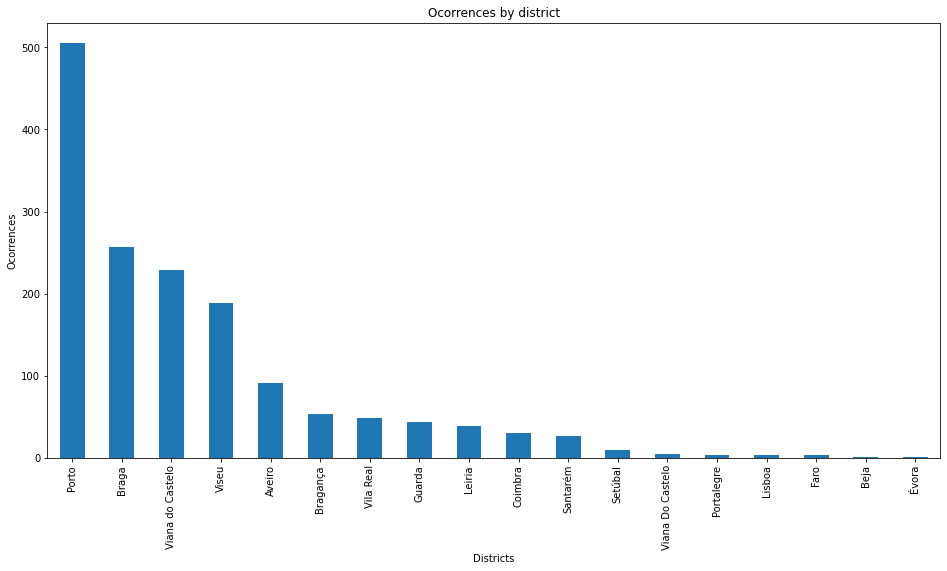

In [257]:
matplotlib.rcParams['figure.figsize'] = [16, 8]
a = reacendimentos.groupby(['Distrito']).sum()['Count'].sort_values(ascending=False)
b = nao_reacendimentos.groupby(['Distrito']).sum()['Count'].sort_values(ascending=False)
a.plot.bar()
matplotlib.pyplot.title('Ocorrences by district')
matplotlib.pyplot.xlabel('Districts')
matplotlib.pyplot.ylabel('Ocorrences')

<AxesSubplot:xlabel='Distrito'>

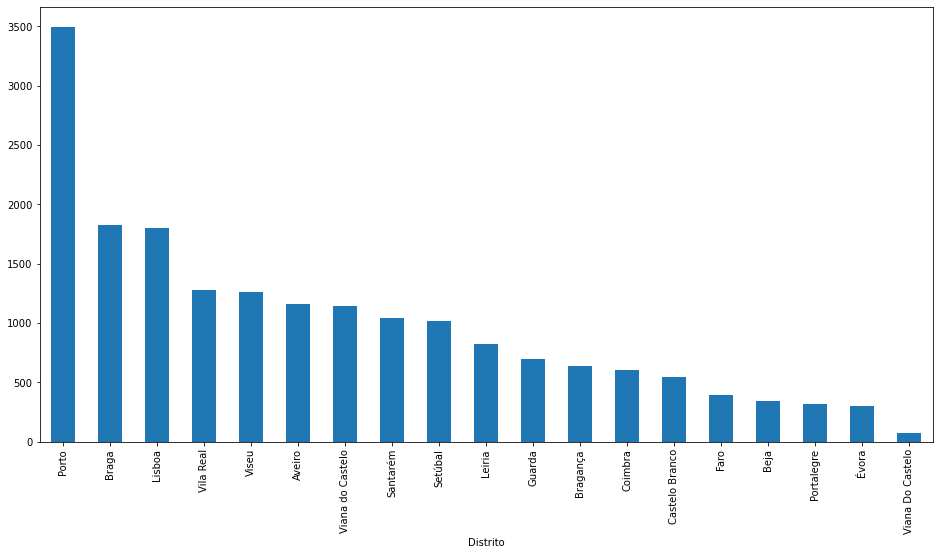

In [258]:
b.plot.bar()

In [167]:
maiores_dist = reacendimentos.loc[(reacendimentos['Distrito'] == 'Porto') | (reacendimentos['Distrito'] == 'Braga') | (reacendimentos['Distrito'] == 'Viana do Castelo') | (reacendimentos['Distrito'] == 'Viseu')]
menores_dist = reacendimentos.loc[(reacendimentos['Distrito'] != 'Porto') & (reacendimentos['Distrito'] != 'Braga') & (reacendimentos['Distrito'] != 'Viana do Castelo') & (reacendimentos['Distrito'] != 'Viseu')]
maiores_dist.describe()

,Ano,Codigo_ANPC,INE,x,y,TempoExtincao,TempoIntervencao,FonteAlerta,AA_Povoamento (ha),AA_Mato (ha),...,AA_EspacosFlorestais (pov+mato)(ha),AA_Total (pov+mato+agric) (ha),Reacendimentos,Queimada,Falso Alarme,Fogacho,Incendio,Agricola,Causa,Count
count,1164.0,1.164000e+03,1164.000000,1164.000000,1164.000000,1164,1164,0.0,1164.000000,1164.000000,...,1164.000000,1164.000000,1164.000000,1164.000000,1164.0,1164.000000,1164.000000,1164.000000,1164.0,1164.0
mean,2015.0,2.015122e+12,122703.685567,186919.932990,488111.336770,0 days 02:17:00.979381443,0 days 00:11:48.041237113,NaN,1.294151,1.353818,...,2.647969,2.653553,0.954467,0.006014,0.0,0.826460,0.151203,0.016323,711.0,1.0
std,0.0,5.180546e+07,51953.470835,24204.834498,38207.292178,0 days 03:33:36.285268577,0 days 00:15:24.761285002,NaN,19.698553,18.002817,...,37.211798,37.211516,0.208559,0.077348,0.0,0.378876,0.358400,0.126769,0.0,0.0
min,2015.0,2.015030e+12,30112.000000,139400.000000,380603.000000,0 days 00:05:00,0 days 00:00:00,NaN,0.000000,0.000000,...,0.000000,0.000100,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,711.0,1.0
25%,2015.0,2.015130e+12,130122.750000,166104.000000,472755.500000,0 days 01:02:45,0 days 00:06:00,NaN,0.000000,0.000500,...,0.010000,0.010000,1.000000,0.000000,0.0,1.000000,0.000000,0.000000,711.0,1.0
50%,2015.0,2.015130e+12,130710.000000,189805.000000,485154.500000,0 days 01:40:00,0 days 00:10:00,NaN,0.000000,0.020000,...,0.050000,0.050000,1.000000,0.000000,0.0,1.000000,0.000000,0.000000,711.0,1.0
75%,2015.0,2.015160e+12,160706.750000,200568.500000,514979.000000,0 days 02:38:00,0 days 00:15:00,NaN,0.036250,0.100000,...,0.300000,0.300000,1.000000,0.000000,0.0,1.000000,0.000000,0.000000,711.0,1.0
max,2015.0,2.015180e+12,182411.000000,262697.000000,575885.000000,3 days 19:25:00,0 days 07:00:00,NaN,550.000000,555.000000,...,1105.000000,1105.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,711.0,1.0


In [169]:
menores_dist.describe()

,Ano,Codigo_ANPC,INE,x,y,TempoExtincao,TempoIntervencao,FonteAlerta,AA_Povoamento (ha),AA_Mato (ha),...,AA_EspacosFlorestais (pov+mato)(ha),AA_Total (pov+mato+agric) (ha),Reacendimentos,Queimada,Falso Alarme,Fogacho,Incendio,Agricola,Causa,Count
count,344.0,3.440000e+02,344.000000,344.000000,344.000000,344,344,0.0,344.000000,344.000000,...,344.000000,344.000000,344.000000,344.000000,344.0,344.000000,344.000000,344.000000,344.0,344.0
mean,2015.0,2.015078e+12,79070.116279,210842.180233,400939.441860,0 days 02:25:32.965116279,0 days 00:13:04.534883720,NaN,1.424476,3.766707,...,5.191183,5.194301,0.866279,0.005814,0.0,0.758721,0.188953,0.046512,711.0,1.0
std,0.0,5.623293e+07,56436.577637,53276.176484,94850.675391,0 days 03:53:54.348552298,0 days 00:12:33.701315010,NaN,16.194507,30.944535,...,37.221821,37.221396,0.340848,0.076138,0.0,0.428482,0.392042,0.210897,0.0,0.0
min,2015.0,2.015010e+12,10104.000000,106337.000000,22068.000000,0 days 00:05:00,0 days 00:00:00,NaN,0.000000,0.000000,...,0.000000,0.000050,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,711.0,1.0
25%,2015.0,2.015018e+12,19029.000000,168824.750000,341603.750000,0 days 01:00:00,0 days 00:07:00,NaN,0.000000,0.000000,...,0.010000,0.010000,1.000000,0.000000,0.0,1.000000,0.000000,0.000000,711.0,1.0
50%,2015.0,2.015085e+12,85854.500000,194316.500000,406410.000000,0 days 01:50:00,0 days 00:11:00,NaN,0.000000,0.006300,...,0.060000,0.064050,1.000000,0.000000,0.0,1.000000,0.000000,0.000000,711.0,1.0
75%,2015.0,2.015120e+12,125776.750000,248821.500000,469891.000000,0 days 02:40:00,0 days 00:16:00,NaN,0.063425,0.100000,...,0.452500,0.462200,1.000000,0.000000,0.0,1.000000,0.000000,0.000000,711.0,1.0
max,2015.0,2.015170e+12,171420.000000,326709.000000,552212.000000,2 days 08:40:00,0 days 02:57:00,NaN,282.400000,520.140000,...,520.140000,520.140000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,711.0,1.0


Podemos comparar entre estas duas tabelas que em média a àrea total dos fogos em hectares para os distritos com maior numero de ocorrencias de fogos é cerca de metade do que a àrea dos distritos com menor numero de ocorrencias. O que nos permite concluir que a maior parte dos reacendimentos foram pequenos fogos. 

array([[<AxesSubplot:title={'center':'Agrícola'}>,
        <AxesSubplot:title={'center':'Florestal'}>],
       [<AxesSubplot:title={'center':'Queimada'}>, <AxesSubplot:>]],
      dtype=object)

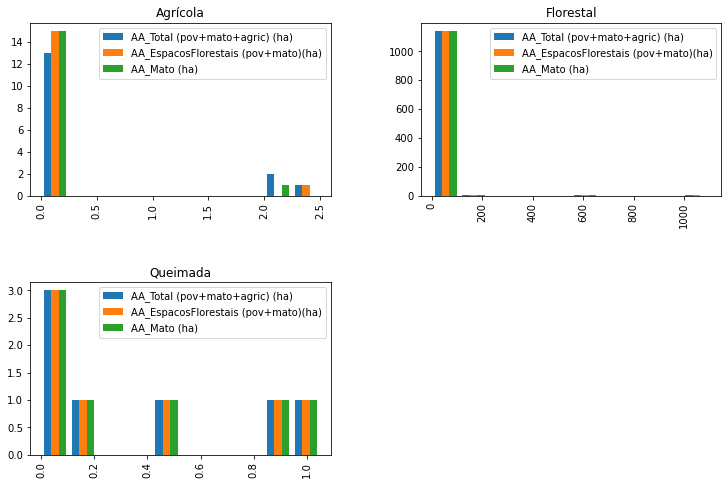

In [170]:
maiores_dist_slim = maiores_dist.loc[:,['Tipo', 'Litoralidade', 'TempoExtincao', 'Distrito','TempoIntervencao', 'AA_Total (pov+mato+agric) (ha)','AA_EspacosFlorestais (pov+mato)(ha)','AA_Mato (ha)']]
maiores_dist_slim.hist(by='Tipo',column=['AA_Total (pov+mato+agric) (ha)','AA_EspacosFlorestais (pov+mato)(ha)','AA_Mato (ha)'],  bins = 10, figsize=[12,8], linewidth=1, legend=True)



array([[<AxesSubplot:title={'center':'Agrícola'}>,
        <AxesSubplot:title={'center':'Florestal'}>],
       [<AxesSubplot:title={'center':'Queimada'}>, <AxesSubplot:>]],
      dtype=object)

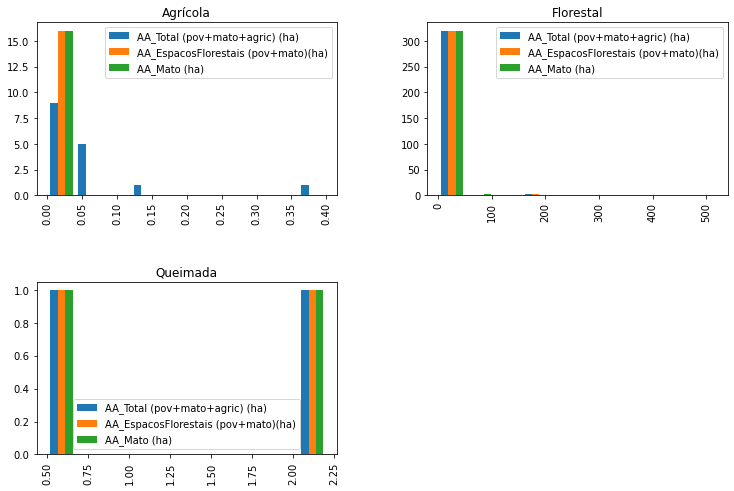

In [171]:
menores_dist_slim = menores_dist.loc[:,['Tipo', 'Litoralidade', 'TempoExtincao', 'Distrito','TempoIntervencao', 'AA_Total (pov+mato+agric) (ha)','AA_EspacosFlorestais (pov+mato)(ha)','AA_Mato (ha)']]
menores_dist_slim.hist(by='Tipo',column=['AA_Total (pov+mato+agric) (ha)','AA_EspacosFlorestais (pov+mato)(ha)','AA_Mato (ha)'],  bins = 10, figsize=[12,8], linewidth=1, legend=True)


Por observação destes 2 histogramas podemos observar que o numero de ocorrências de fogos nos distritos com menor ocorrència são muito semelhantes entre Litoral e Interior mas o mesmo não se verifica para os distritos com maior numero de ocorrência. O que nos leva a questionar se existe mesmo uma correlação entre a litoralidade e o numero de reacendimentos.

Text(0, 0.5, 'Ocorrences')

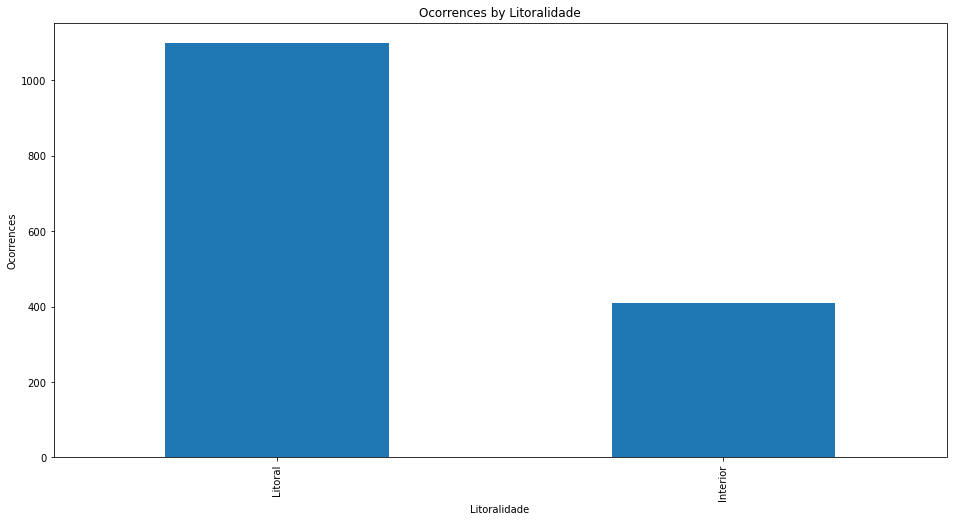

In [178]:
a = reacendimentos.groupby(['Litoralidade']).sum()['Count'].sort_values(ascending=False)
a.plot.bar()
matplotlib.pyplot.title('Ocorrences by Litoralidade')
matplotlib.pyplot.xlabel('Litoralidade')
matplotlib.pyplot.ylabel('Ocorrences')

Text(0, 0.5, 'AA_Total (ha)')

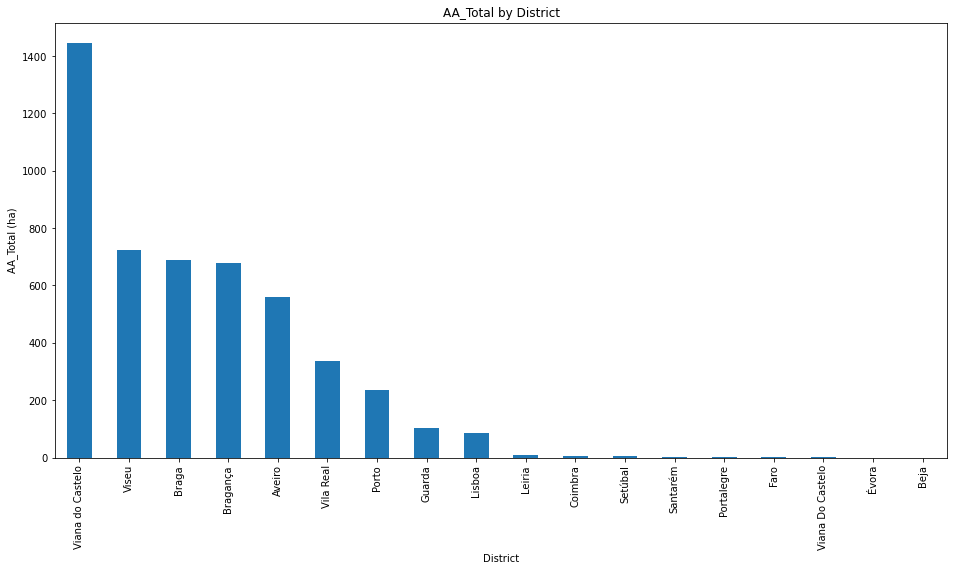

In [9]:
x = reacendimentos.groupby(['Distrito']).sum()['AA_Total (pov+mato+agric) (ha)'].sort_values(ascending=False)
x.plot.bar()
matplotlib.pyplot.title('AA_Total by District')
matplotlib.pyplot.xlabel('District')
matplotlib.pyplot.ylabel('AA_Total (ha)')

Text(0, 0.5, 'AA_Total (ha)')

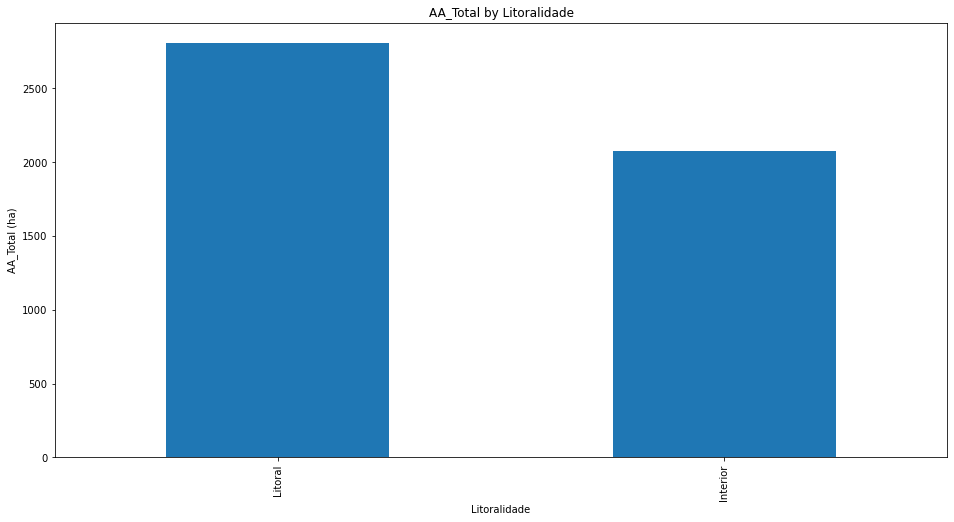

In [10]:
x = reacendimentos.groupby(['Litoralidade']).sum()['AA_Total (pov+mato+agric) (ha)'].sort_values(ascending=False)
x.plot.bar()
matplotlib.pyplot.title('AA_Total by Litoralidade')
matplotlib.pyplot.xlabel('Litoralidade')
matplotlib.pyplot.ylabel('AA_Total (ha)')

Text(0, 0.5, 'District')

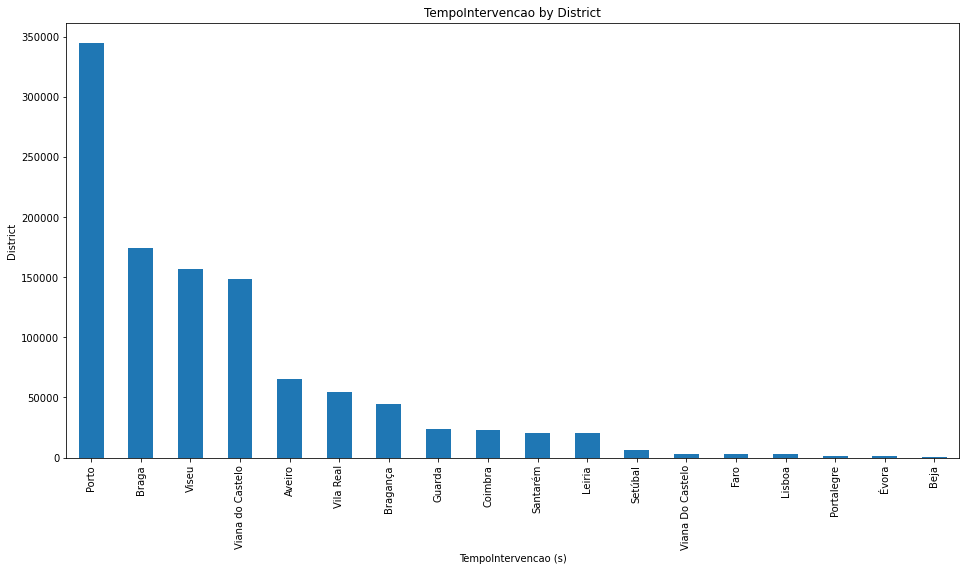

In [11]:
y = reacendimentos_slim_delta.groupby(['Distrito']).sum()['TempoIntervencao'].sort_values(ascending=False)
y.plot.bar()
matplotlib.pyplot.title('TempoIntervencao by District')
matplotlib.pyplot.xlabel('TempoIntervencao (s)')
matplotlib.pyplot.ylabel('District')

Text(0, 0.5, 'Litoralidade')

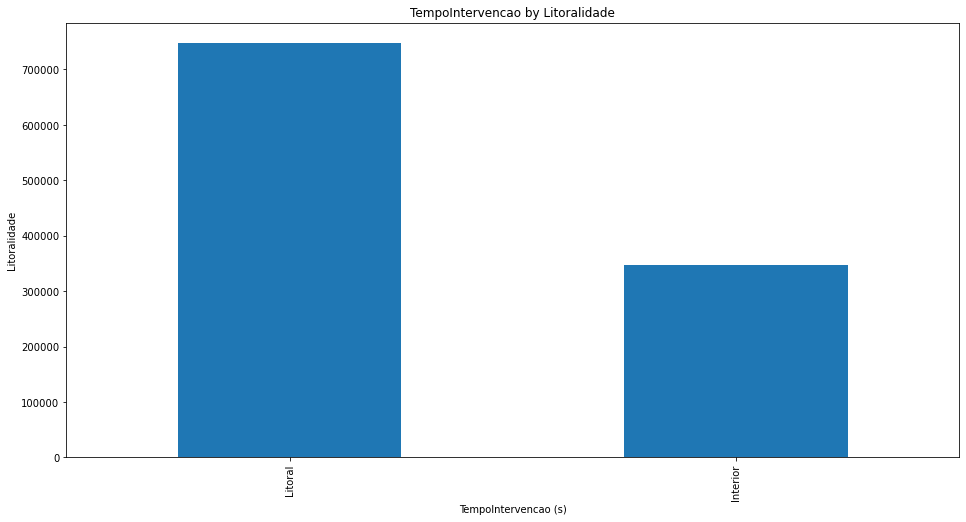

In [12]:
y = reacendimentos_slim_delta.groupby(['Litoralidade']).sum()['TempoIntervencao'].sort_values(ascending=False)
y.plot.bar()
matplotlib.pyplot.title('TempoIntervencao by Litoralidade')
matplotlib.pyplot.xlabel('TempoIntervencao (s)')
matplotlib.pyplot.ylabel('Litoralidade')

Text(0, 0.5, 'Litoralidade')

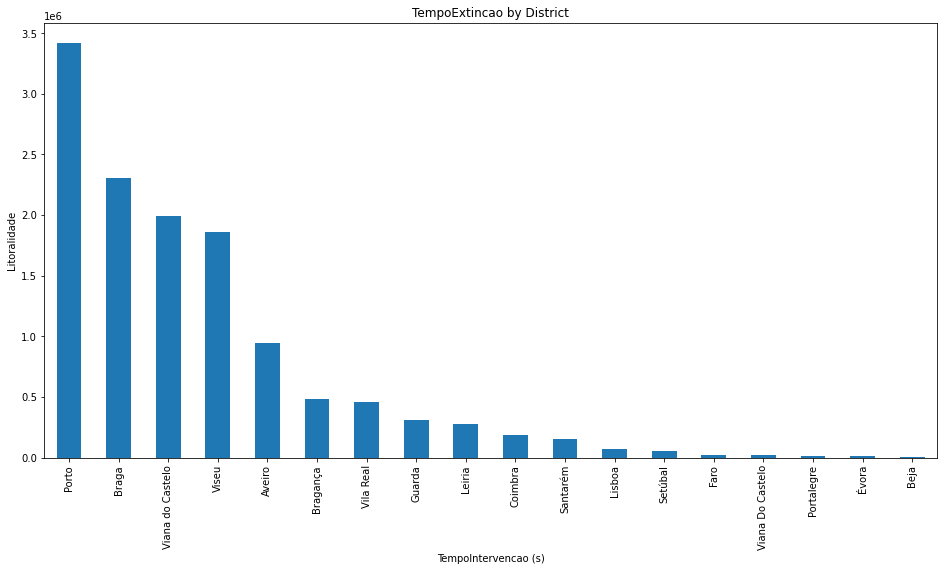

In [13]:
z = reacendimentos_slim_delta.groupby(['Distrito']).sum()['TempoExtincao'].sort_values(ascending=False)
z.plot.bar()
matplotlib.pyplot.title('TempoExtincao by District')
matplotlib.pyplot.xlabel('TempoIntervencao (s)')
matplotlib.pyplot.ylabel('Litoralidade')

Text(0, 0.5, 'Litoralidade')

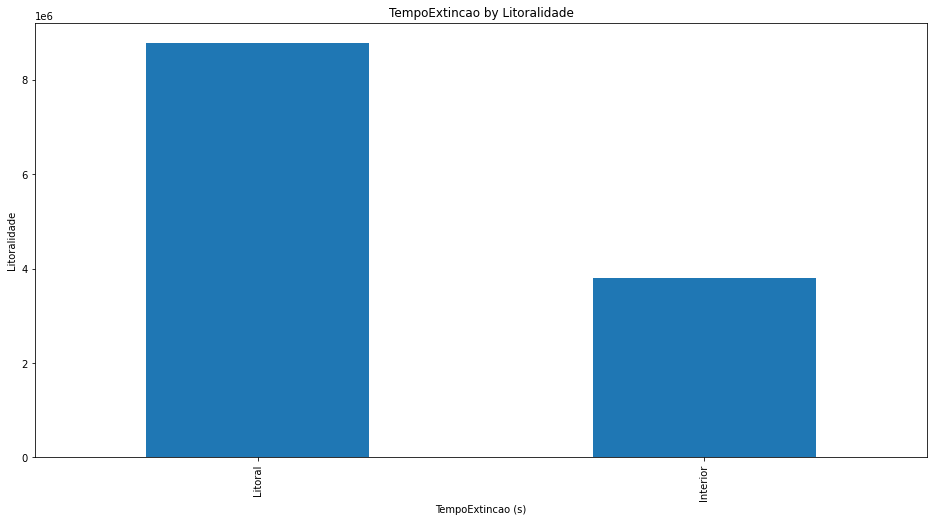

In [14]:
z = reacendimentos_slim_delta.groupby(['Litoralidade']).sum()['TempoExtincao'].sort_values(ascending=False)
z.plot.bar()
matplotlib.pyplot.title('TempoExtincao by Litoralidade')
matplotlib.pyplot.xlabel('TempoExtincao (s)')
matplotlib.pyplot.ylabel('Litoralidade')

In [16]:
reacendimentos_slim = reacendimentos.loc[:,['Tipo', 'Litoralidade', 'TempoExtincao', 'Distrito',
                                            'TempoIntervencao', 'AA_Total (pov+mato+agric) (ha)' ]]

reacendimentos_slim = reacendimentos_slim[reacendimentos_slim.Tipo != 'Falso Alarme']

reacendimentos_slim.head()

,Tipo,Litoralidade,TempoExtincao,Distrito,TempoIntervencao,AA_Total (pov+mato+agric) (ha)
5,Florestal,Litoral,0 days 07:35:00,Braga,0 days 00:12:00,1.50
15,Florestal,Interior,0 days 00:50:00,Vila Real,0 days 00:20:00,0.10
43,Florestal,Litoral,0 days 00:58:00,Braga,0 days 00:04:00,0.05
145,Florestal,Interior,0 days 03:53:00,Viseu,0 days 00:20:00,0.10
237,Florestal,Litoral,0 days 02:54:00,Porto,0 days 00:05:00,0.20


In [17]:
#Se for necessário trabalhar em segundos

reacendimentos_slim_delta = reacendimentos_slim.copy()
reacendimentos_slim_delta['TempoExtincao'] = reacendimentos_slim_delta['TempoExtincao'].astype('int64') // 10**9
reacendimentos_slim_delta['TempoIntervencao'] = reacendimentos_slim_delta['TempoIntervencao'].astype('int64') // 10**9
reacendimentos_slim_delta

/var/folders/zb/q2q0b14j1wx8tdztc_894g9c0000gn/T/ipykernel_2675/3043261933.py:4: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  reacendimentos_slim_delta['TempoExtincao'] = reacendimentos_slim_delta['TempoExtincao'].astype('int64') // 10**9
/var/folders/zb/q2q0b14j1wx8tdztc_894g9c0000gn/T/ipykernel_2675/3043261933.py:5: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  reacendimentos_slim_delta['TempoIntervencao'] = reacendimentos_slim_delta['TempoIntervencao'].astype('int64') // 10**9


,Tipo,Litoralidade,TempoExtincao,Distrito,TempoIntervencao,AA_Total (pov+mato+agric) (ha)
5,Florestal,Litoral,27300,Braga,720,1.500
15,Florestal,Interior,3000,Vila Real,1200,0.100
43,Florestal,Litoral,3480,Braga,240,0.050
145,Florestal,Interior,13980,Viseu,1200,0.100
237,Florestal,Litoral,10440,Porto,300,0.200
...,...,...,...,...,...,...
23130,Florestal,Interior,8280,Viseu,720,0.045
23143,Florestal,Litoral,3060,Viana do Castelo,840,0.100
23145,Florestal,Litoral,8700,Porto,360,0.300
23167,Florestal,Litoral,10620,Porto,960,0.070


<h3> Statistical summary for quantitative data

In [ ]:
stat_summary = reacendimentos_slim_delta.describe()
stat_summary.loc['range'] = stat_summary.loc['max'] - stat_summary.loc['min']
stat_summary.loc['IQR'] = stat_summary.loc['75%'] - stat_summary.loc['25%'] # appending interquartile range
stat_summary.loc['G.M.'] = stat.gmean(reacendimentos_slim_delta.iloc[:,2:], axis=0)
stat_summary.loc['H.M.'] = stat.hmean(reacendimentos_slim_delta.iloc[:,2:], axis=0)
mode = reacendimentos_slim_delta.mode(numeric_only=True, axis=0)
stat_summary.loc['var'] = reacendimentos_slim_delta.var(numeric_only=True, axis=0)
stat_summary.loc['median'] = reacendimentos_slim_delta.median( numeric_only=True, axis=0)
stat_summary.loc['skew'] = reacendimentos_slim_delta.skew(numeric_only=True, axis=0)
stat_summary.loc['kurt'] =  reacendimentos_slim_delta.kurt(numeric_only=True, axis=0)
stat_summary.loc['mad'] = reacendimentos_slim_delta.mad(axis=0)

stat_summary = pd.concat([stat_summary, mode], axis=0)
stat_summary.rename(index ={0: 'mode'}, inplace = True)
#for results in seconds
stat_summary


In [18]:
#Results in timedelta
stat_summary_final = stat_summary.copy()
stat_summary_final['TempoExtincao'] = stat_summary['TempoExtincao'].apply(lambda x: x*10**9).copy()
stat_summary_final['TempoIntervencao'] =stat_summary['TempoIntervencao'].apply(lambda x: x*10**9).copy()

stat_summary_final_delta = stat_summary_final.copy()
stat_summary_final_delta['TempoExtincao'] = stat_summary_final_delta['TempoExtincao'].apply(lambda x: pd.to_timedelta(x)).copy()
stat_summary_final_delta['TempoIntervencao'] = stat_summary_final_delta['TempoIntervencao'].apply(lambda x: pd.to_timedelta(x)).copy()
# stat_summary_final.delta

stat_summary_final_delta

,TempoExtincao,TempoIntervencao,AA_Total (pov+mato+agric) (ha)
count,0 days 00:25:08,0 days 00:25:08,1508.000000
mean,0 days 02:18:57.771883289,0 days 00:12:05.490716180,3.233140
std,0 days 03:38:21.081607726,0 days 00:14:48.986859078,37.216702
min,0 days 00:05:00,0 days 00:00:00,0.000050
25%,0 days 01:02:00,0 days 00:06:00,0.010000
50%,0 days 01:43:00,0 days 00:10:00,0.050000
75%,0 days 02:40:00,0 days 00:15:00,0.302500
max,3 days 19:25:00,0 days 07:00:00,1105.000000
range,3 days 19:20:00,0 days 07:00:00,1104.999950
IQR,0 days 01:38:00,0 days 00:09:00,0.292500


<h3>Plotting histogram and boxplot for AA

ERROR! Session/line number was not unique in database. History logging moved to new session 104


Text(0.5, 1.0, 'AA_T_20')

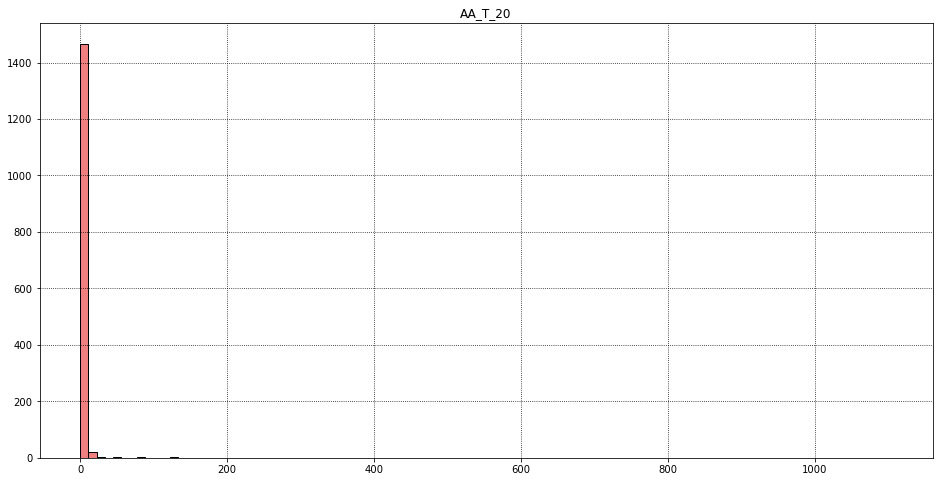

In [19]:
plot_AA = reacendimentos_slim.hist(column='AA_Total (pov+mato+agric) (ha)', bins = 100, edgecolor='black', color = 'lightcoral', 
                          linewidth=1)
# Customize grid
matplotlib.pyplot.grid(color='black', linestyle=':')
matplotlib.pyplot.title('AA_T_20')
# matplotlib.axes.Axes.set_xticks(np.arange(0, 11, 0.5))

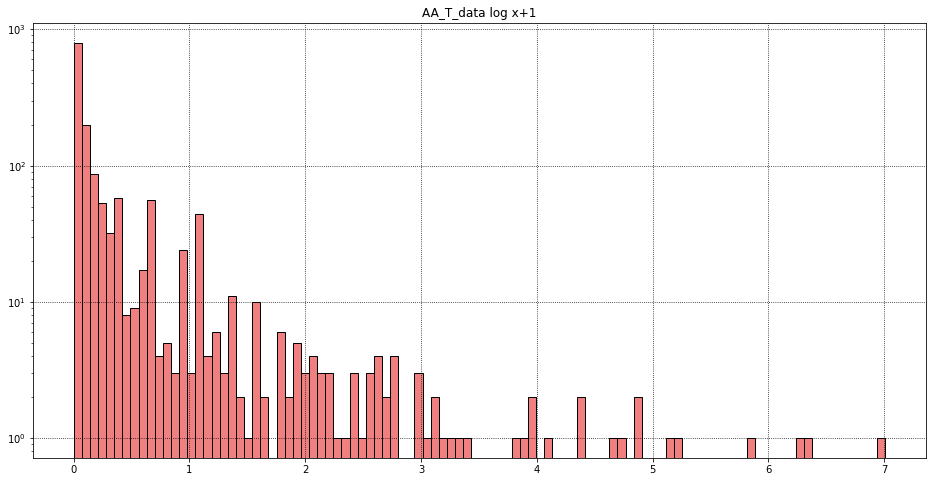

In [20]:
# Adjusting data for log
log_reacendimentos_slim = reacendimentos_slim
log_reacendimentos_slim['log_AA'] = np.log1p(reacendimentos_slim['AA_Total (pov+mato+agric) (ha)'])
log_reacendimentos_slim['log_AA'].hist(bins = 100, edgecolor='black', color = 'lightcoral', 
                          linewidth=1)

matplotlib.pyplot.grid(color='black', linestyle=':')
matplotlib.pyplot.title('AA_T_data log x+1')
# matplotlib.axes.Axes.set_xticks(np.arange(0, 11, 0.5))

matplotlib.pyplot.yscale('log')

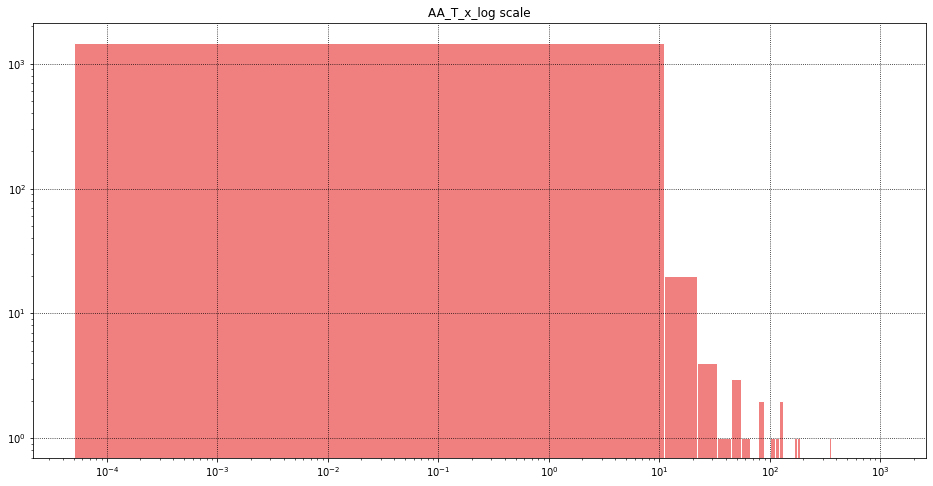

In [21]:
#Adjusting scale to log 

reacendimentos_slim['AA_Total (pov+mato+agric) (ha)'].hist(bins = 100, edgecolor='white', color = 'lightcoral', 
                          linewidth=1, log=True)
matplotlib.pyplot.grid(color='black', linestyle=':')
matplotlib.pyplot.title('AA_T_x_log scale')
# matplotlib.axes.Axes.set_xticks(np.arange(0, 11, 0.5))

matplotlib.pyplot.xscale('log', base=10)

Text(0.5, 1.0, 'AA_T_0 to 1 ha')

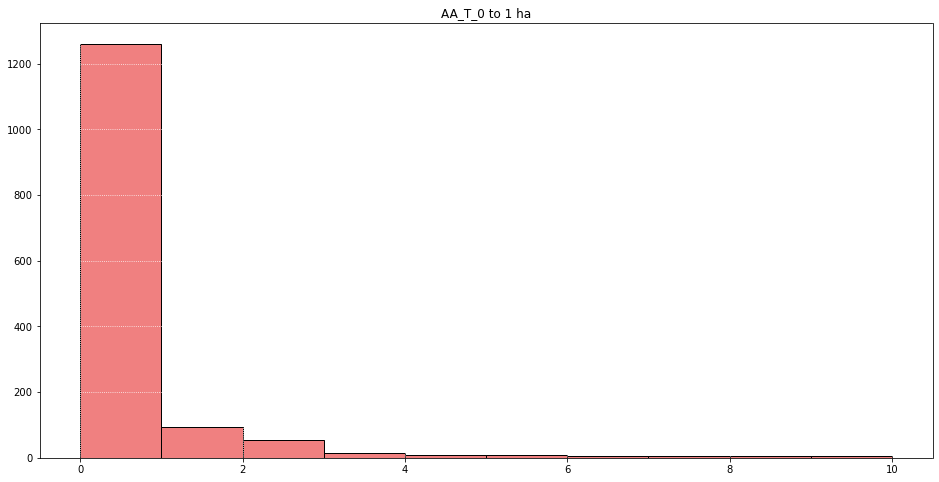

In [22]:
reacendimentos_slim['AA_Total (pov+mato+agric) (ha)'].hist(bins = 10, range=[0,10], edgecolor='black', color = 'lightcoral', 
                          linewidth=1)
matplotlib.pyplot.grid(color='white', linestyle=':')
matplotlib.pyplot.title('AA_T_0 to 1 ha')
# matplotlib.axes.Axes.set_xticks(np.arange(0, 11, 0.5))

# matplotlib.pyplot.xscale('log', base=10)

Text(0.5, 1.0, 'AA_T_0 to 1 ha')

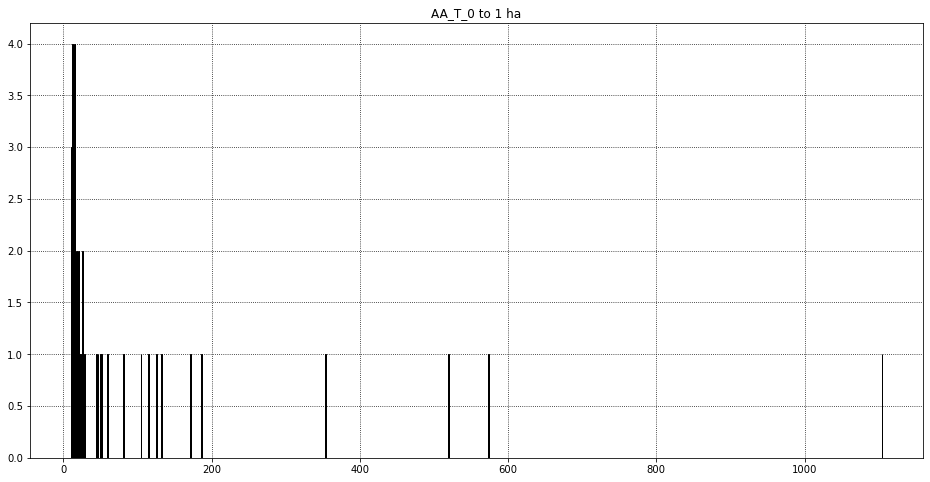

In [23]:
reacendimentos_slim['AA_Total (pov+mato+agric) (ha)'].hist(bins = 1000, range=[10,1105], edgecolor='black', color = 'lightcoral', 
                          linewidth=1)
matplotlib.pyplot.grid(color='black', linestyle=':')
matplotlib.pyplot.title('AA_T_0 to 1 ha')

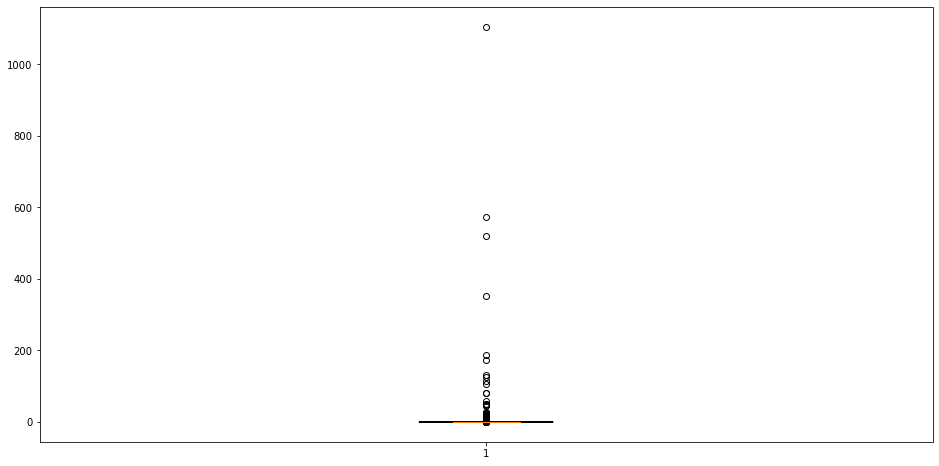

In [24]:
fig, ax = matplotlib.pyplot.subplots()
ax.boxplot(reacendimentos_slim['AA_Total (pov+mato+agric) (ha)'],patch_artist=True ,notch = True, flierprops=dict(color='black', markeredgecolor='black'), 
           whiskerprops=dict(color='black'), boxprops=dict(color='black', facecolor='lightcoral'), capprops=dict(color='black'))
matplotlib.pyplot.show()

In [25]:
# Filtering data for AA_total < max upper whisker (outliers)
reacendimentos_slim_wpo = reacendimentos_slim_delta.rename(columns = {'AA_Total (pov+mato+agric) (ha)': 'AA_total_ha'})
reacendimentos_slim_wpo = reacendimentos_slim_wpo[reacendimentos_slim_wpo['TempoExtincao'] < (stat_summary.loc['75%']+1.5*stat_summary.loc['IQR'])[0]]
reacendimentos_slim_wpo = reacendimentos_slim_wpo[reacendimentos_slim_wpo['TempoIntervencao'] < (stat_summary.loc['75%']+1.5*stat_summary.loc['IQR'])[1]]
reacendimentos_slim_wpo = reacendimentos_slim_wpo[reacendimentos_slim_wpo['AA_total_ha'] < (stat_summary.loc['75%']+1.5*stat_summary.loc['IQR'])[2]]


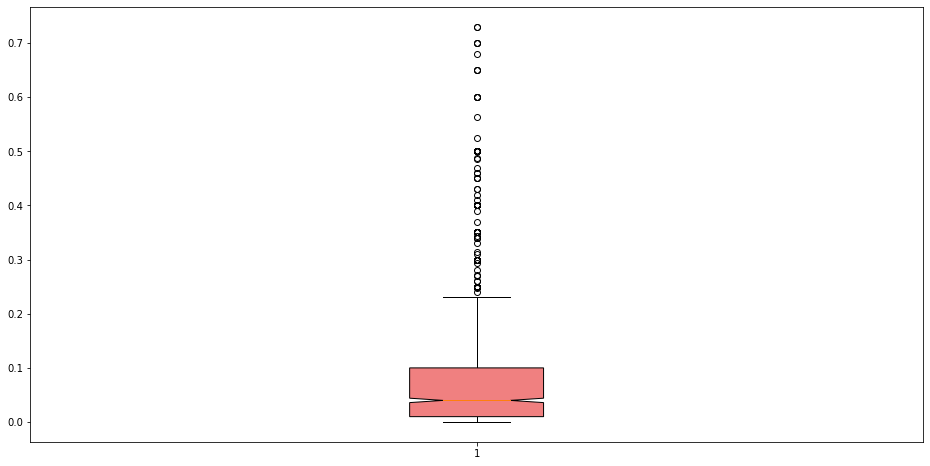

In [26]:
fig, ax = matplotlib.pyplot.subplots()
ax.boxplot(reacendimentos_slim_wpo['AA_total_ha'], patch_artist=True ,notch = True, flierprops=dict(color='black', markeredgecolor='black'), 
           whiskerprops=dict(color='black'), boxprops=dict(color='black', facecolor='lightcoral'), capprops=dict(color='black'))
matplotlib.pyplot.show()


<h3>Plotting histogram and boxplot for Tempo de Extinção

Text(0.5, 1.0, 'TempoExtinção')

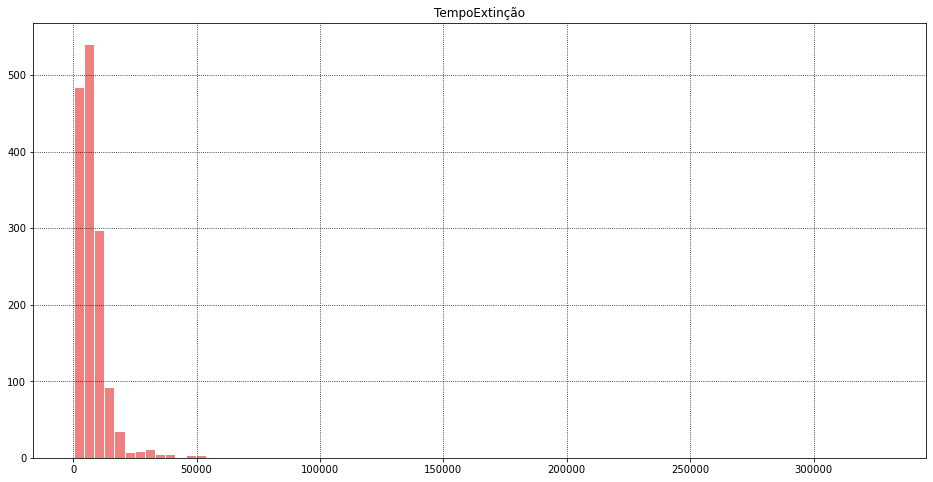

In [27]:
plot_TE = reacendimentos_slim_delta.hist(column='TempoExtincao', bins = 80, edgecolor='white', color = 'lightcoral', 
                          linewidth=1)
# Customize grid
matplotlib.pyplot.grid(color='black', linestyle=':')
matplotlib.pyplot.title('TempoExtinção')
# matplotlib.axes.Axes.set_xticks(np.arange(0, 11, 0.5))

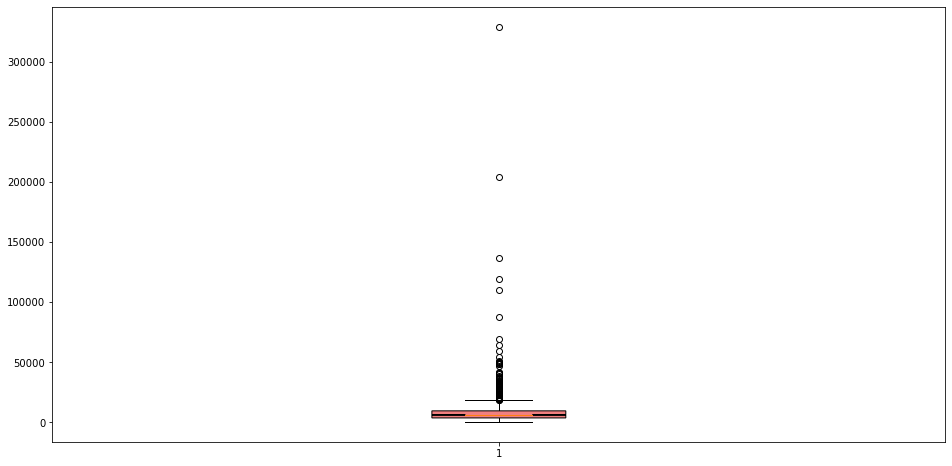

In [28]:
fig, ax = matplotlib.pyplot.subplots()
ax.boxplot(reacendimentos_slim_delta['TempoExtincao'],patch_artist=True ,notch = True, flierprops=dict(color='black', markeredgecolor='black'), 
           whiskerprops=dict(color='black'), boxprops=dict(color='black', facecolor='lightcoral'), capprops=dict(color='black'))
matplotlib.pyplot.show()

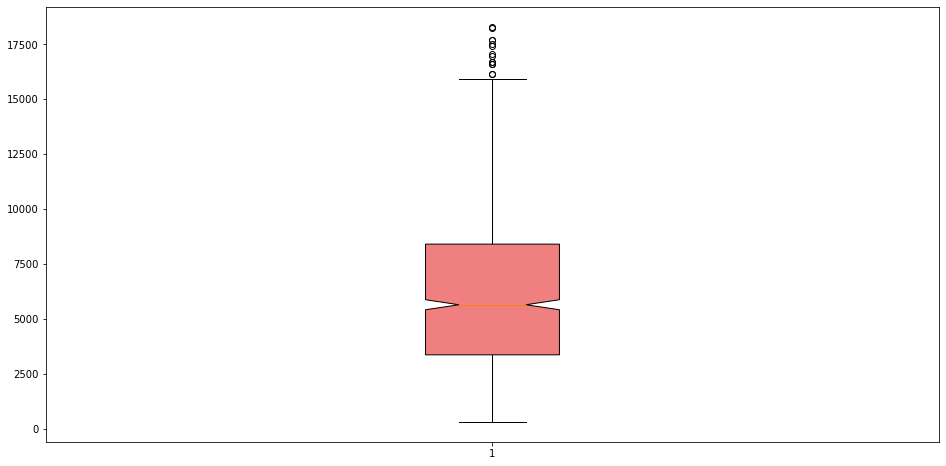

In [29]:
fig, ax = matplotlib.pyplot.subplots()
ax.boxplot(reacendimentos_slim_wpo['TempoExtincao'], patch_artist=True ,notch = True, flierprops=dict(color='black', markeredgecolor='black'), 
           whiskerprops=dict(color='black'), boxprops=dict(color='black', facecolor='lightcoral'), capprops=dict(color='black'))
matplotlib.pyplot.show()

<h3>Plotting histogram and boxplot for Tempo de Intervenção

<AxesSubplot:xlabel='Litoralidade', ylabel='TempoExtincao'>

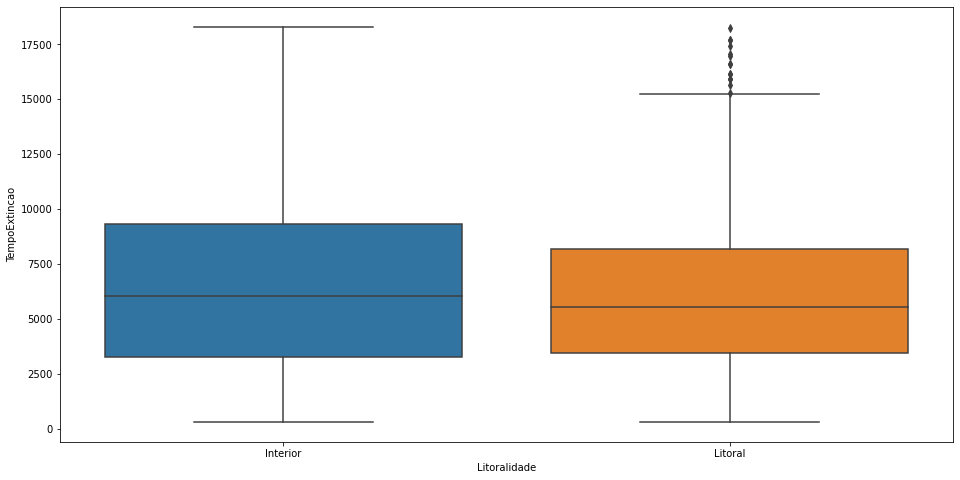

In [30]:
sns.boxplot(x="Litoralidade", y="TempoExtincao", data=reacendimentos_slim_wpo) 

<AxesSubplot:xlabel='Litoralidade', ylabel='TempoIntervencao'>

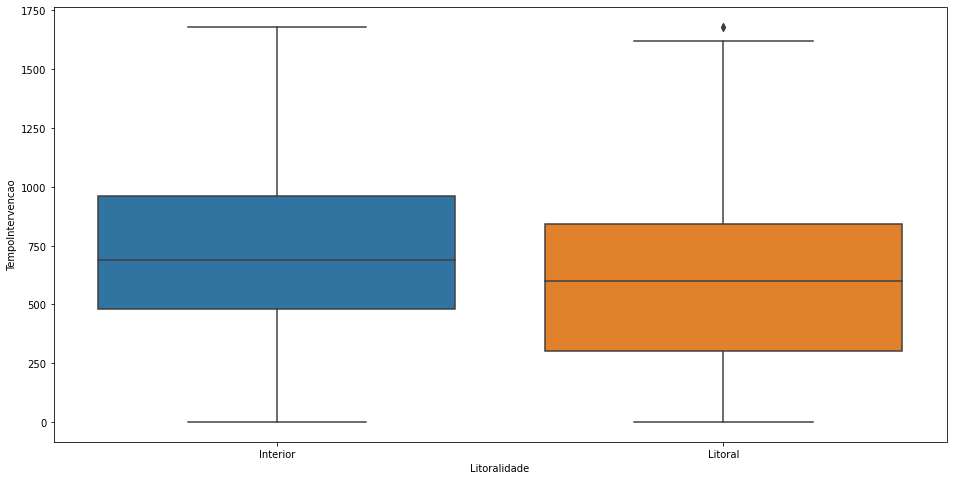

In [31]:
sns.boxplot(x="Litoralidade", y="TempoIntervencao", data=reacendimentos_slim_wpo) 

<AxesSubplot:xlabel='Litoralidade', ylabel='AA_total_ha'>

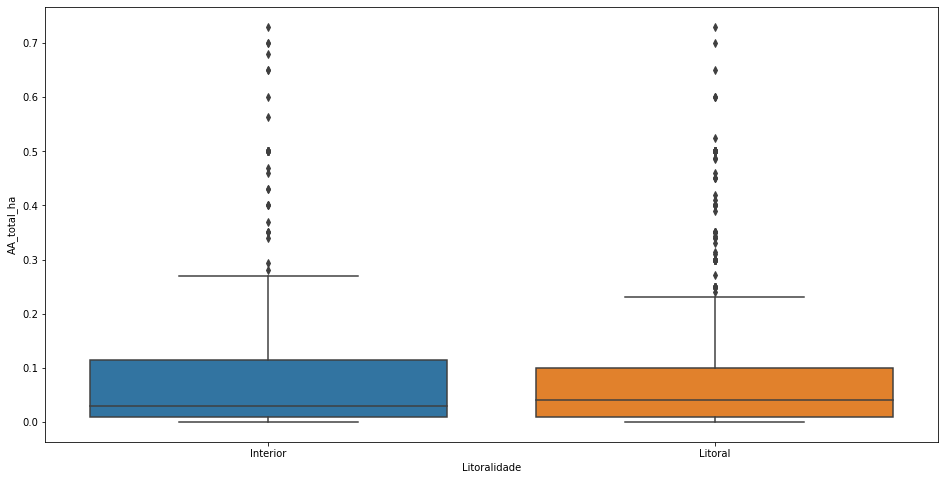

In [32]:
sns.boxplot(x="Litoralidade", y="AA_total_ha", data=reacendimentos_slim_wpo)

Text(0.5, 1.0, 'TempoIntervencao')

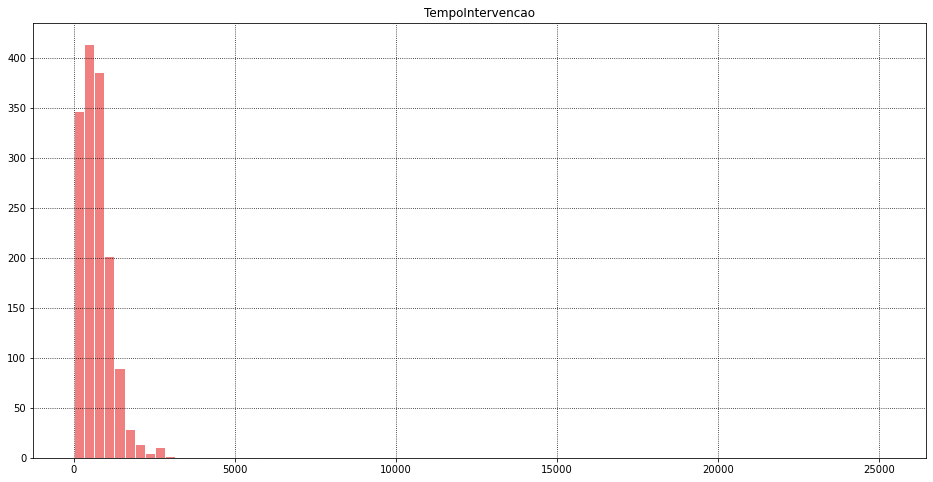

In [33]:
plot_TI = reacendimentos_slim_delta.hist(column='TempoIntervencao', bins = 80, edgecolor='white', color = 'lightcoral', 
                          linewidth=1)
# Customize grid
matplotlib.pyplot.grid(color='black', linestyle=':')
matplotlib.pyplot.title('TempoIntervencao')

Text(0.5, 1.0, 'TempoIntervencao')

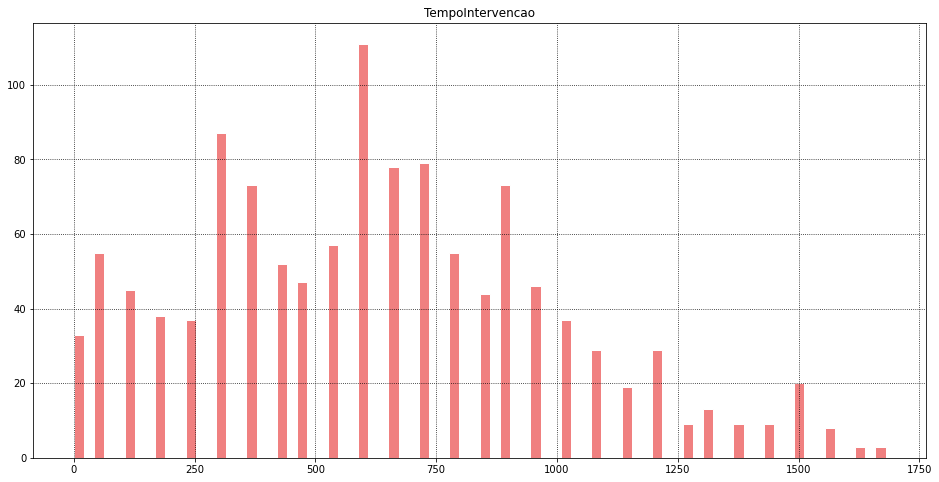

In [34]:
plot_TI = reacendimentos_slim_wpo.hist(column='TempoIntervencao', bins = 80, edgecolor='white', color = 'lightcoral', 
                          linewidth=1)
# Customize grid
matplotlib.pyplot.grid(color='black', linestyle=':')
matplotlib.pyplot.title('TempoIntervencao')

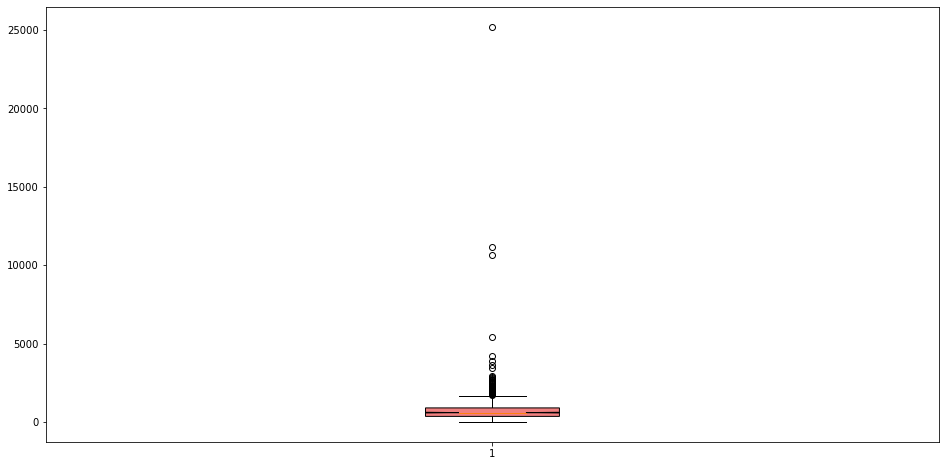

In [35]:
fig, ax = matplotlib.pyplot.subplots()
ax.boxplot(reacendimentos_slim_delta['TempoIntervencao'],patch_artist=True ,notch = True, flierprops=dict(color='black', markeredgecolor='black'), 
           whiskerprops=dict(color='black'), boxprops=dict(color='black', facecolor='lightcoral'), capprops=dict(color='black'))
matplotlib.pyplot.show()

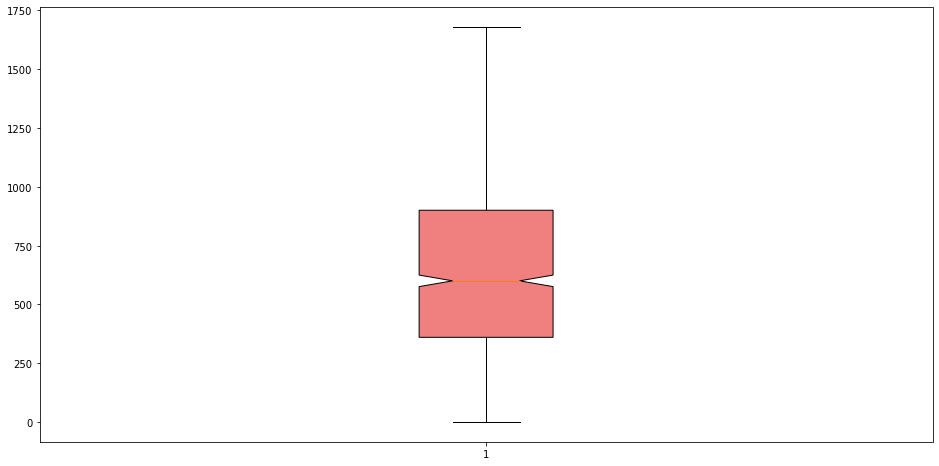

In [36]:
fig, ax = matplotlib.pyplot.subplots()
ax.boxplot(reacendimentos_slim_wpo['TempoIntervencao'], patch_artist=True ,notch = True, flierprops=dict(color='black', markeredgecolor='black'), 
           whiskerprops=dict(color='black'), boxprops=dict(color='black', facecolor='lightcoral'), capprops=dict(color='black'))
matplotlib.pyplot.show()

In [271]:
reacendimentos_slim_wpo_t = reacendimentos_slim_wpo.drop('AA_total_ha', axis=1)
reacendimentos_slim_wpo_t.hist(by='Litoralidade',column=['TempoExtincao', 'TempoIntervencao'],  bins = 10, 
                               figsize=[12,8], linewidth=1, legend=True)

vai co crl

SyntaxError: invalid syntax (3986011601.py, line 5)

In [270]:
reacendimentos_slim_wpo_t.hist(by='Tipo',column=['TempoExtincao', 'TempoIntervencao'],  bins = 10, 
                               figsize=[12,8], linewidth=1, legend=True)

vai co crl

SyntaxError: invalid syntax (735766863.py, line 4)

In [269]:
reacendimentos_slim_wpo.hist(column='AA_total_ha', by='Litoralidade',  bins = 50, edgecolor='white', 
                               color='lightcoral',  
                               figsize=[12,8], linewidth=1, legend=True)
vai co crl

SyntaxError: invalid syntax (2731692206.py, line 4)

In [267]:
reacendimentos_slim_delta.hist(column='AA_Total (pov+mato+agric) (ha)', by='Tipo',  bins = 50, edgecolor='white', 
                               color='lightcoral',  
                               figsize=[12,8], linewidth=1, legend=True)
print('Percentage of Agrícola Fires: ', (32/1508)*100, '%')
print('Percentage of Queimada Fires: ', (9/1508)*100, '%')
print('Percentage of Florestal Fires: ', (1467/1508)*100, '%')

vai co crl

SyntaxError: invalid syntax (1481516217.py, line 8)

In [268]:
reacendimentos_slim_delta.hist(column='TempoIntervencao', by='Litoralidade',  bins = 50, edgecolor='white',
                               color='lightcoral',  
                               figsize=[12,8], linewidth=1, legend = True)
vai co crl

SyntaxError: invalid syntax (979828798.py, line 4)

In [272]:
reacendimentos_slim_wpo.hist(column='TempoIntervencao', by='Tipo',  bins = 50, 
                               color='lightcoral',  
                               figsize=[12,8], linewidth=1, legend = True)
vai co crl

SyntaxError: invalid syntax (3196869466.py, line 4)

In [273]:
reacendimentos_slim_wpo.hist(column='TempoExtincao', by='Litoralidade',  bins = 50, edgecolor='white', 
                               color='lightcoral',  
                               figsize=[12,8], linewidth=1, legend=True)

vai co crl

SyntaxError: invalid syntax (257929544.py, line 5)

<h3>Scatterplot TempoIntervencao vs AA total

<AxesSubplot:title={'center':'TempoIntervecao vs. AA_total'}, xlabel='TempoIntervencao', ylabel='AA_Total (pov+mato+agric) (ha)'>

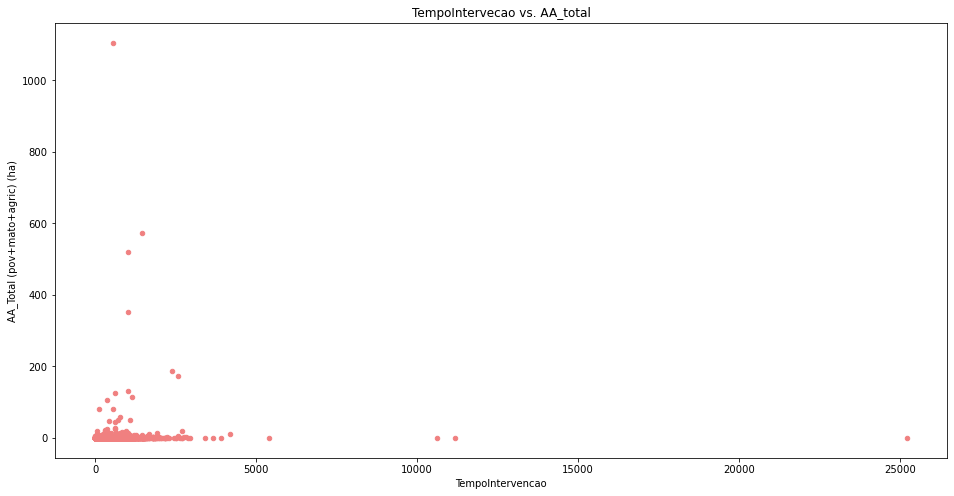

In [44]:
reacendimentos_slim_delta.plot('TempoIntervencao','AA_Total (pov+mato+agric) (ha)', kind='scatter',
                               c='lightcoral', title='TempoIntervecao vs. AA_total')

<AxesSubplot:title={'center':'TempoIntervecao vs. AA_total'}, xlabel='TempoIntervencao', ylabel='AA_total_ha'>

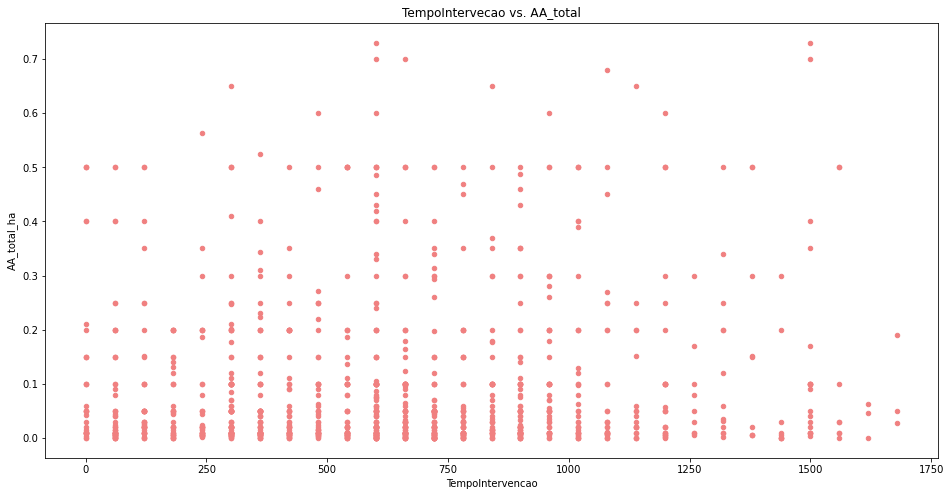

In [45]:
reacendimentos_slim_wpo.plot('TempoIntervencao','AA_total_ha', kind='scatter',
                               c='lightcoral', title='TempoIntervecao vs. AA_total')

<h3>Scatterplot TempoExtincao vs AA total

<AxesSubplot:title={'center':'TempoExtincao vs. AA_total'}, xlabel='TempoExtincao', ylabel='AA_Total (pov+mato+agric) (ha)'>

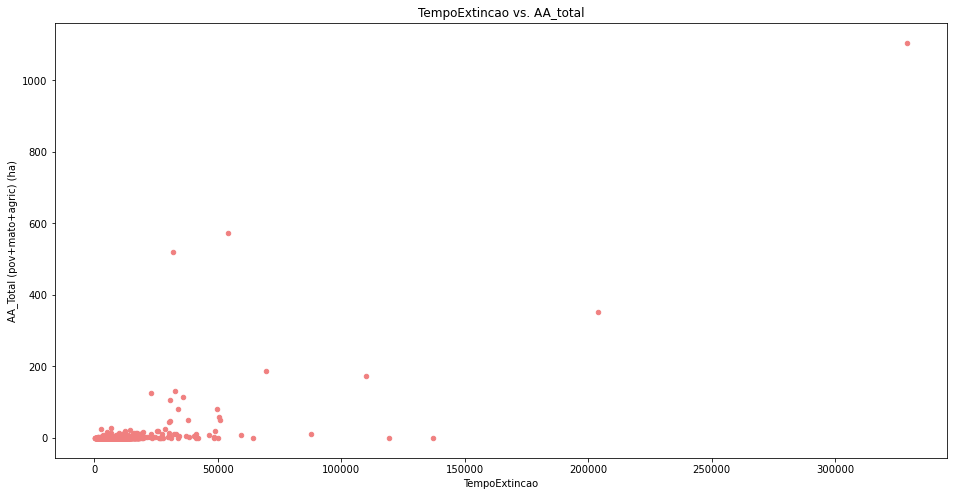

In [46]:
reacendimentos_slim_delta.plot('TempoExtincao','AA_Total (pov+mato+agric) (ha)', kind='scatter',
                               c='lightcoral', title='TempoExtincao vs. AA_total')

<AxesSubplot:title={'center':'TempoExtincao vs. AA_total'}, xlabel='TempoExtincao', ylabel='AA_total_ha'>

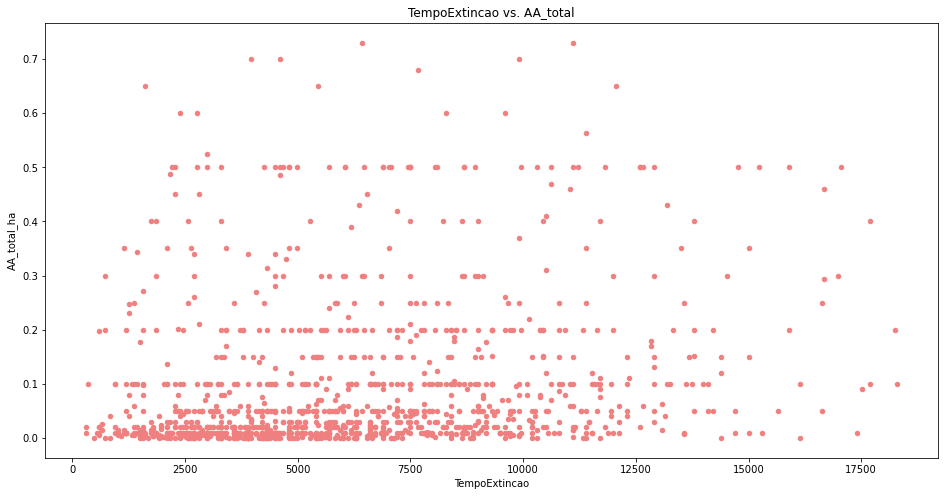

In [244]:
reacendimentos_slim_wpo.plot('TempoExtincao','AA_total_ha', kind='scatter',
                               c='lightcoral', title='TempoExtincao vs. AA_total')

<h3> Scatterplot TempoExtinçao vs TempoIntervençao

<AxesSubplot:title={'center':'TempoExtincao vs TempoIntervencao'}, xlabel='TempoExtincao', ylabel='TempoIntervencao'>

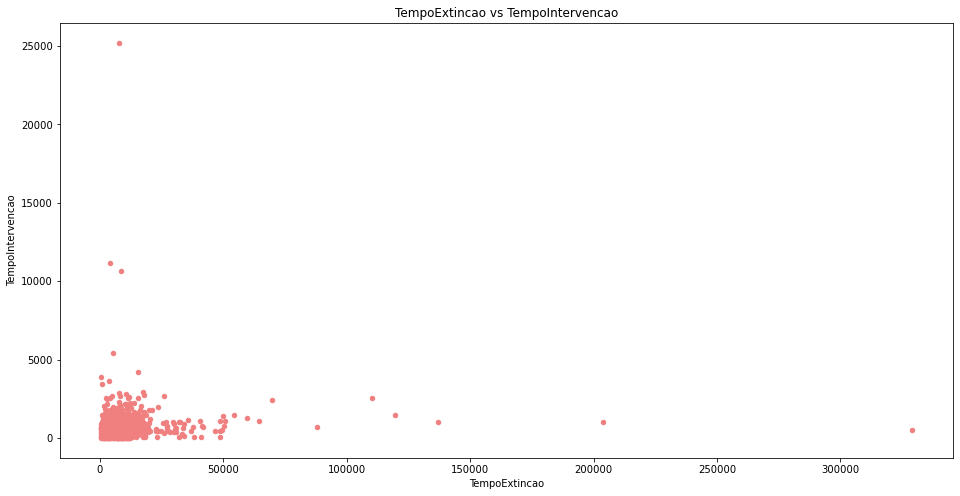

In [48]:
reacendimentos_slim_delta.plot('TempoExtincao','TempoIntervencao', kind='scatter',
                               c='lightcoral', title='TempoExtincao vs TempoIntervencao')

<AxesSubplot:title={'center':'TempoExtincao vs TempoIntervencao'}, xlabel='TempoExtincao', ylabel='TempoIntervencao'>

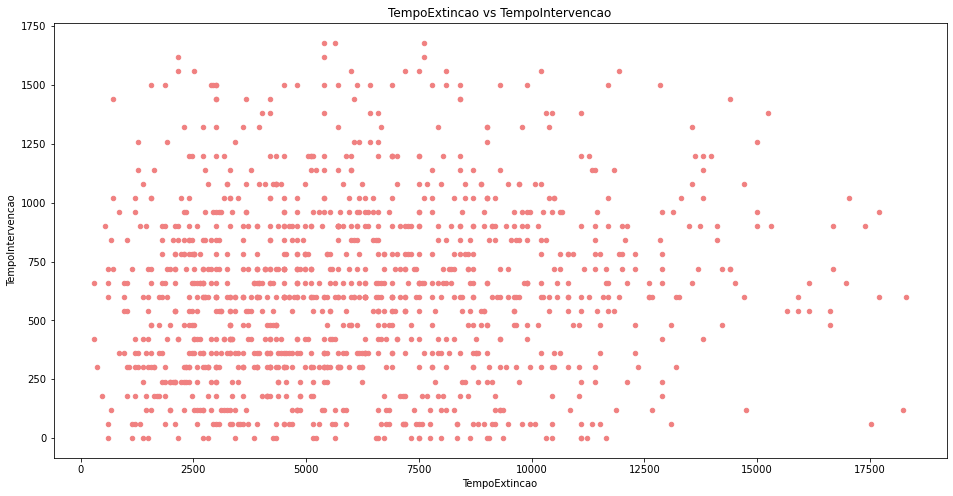

In [49]:
reacendimentos_slim_wpo.plot('TempoExtincao','TempoIntervencao', kind='scatter',
                               c='lightcoral', title='TempoExtincao vs TempoIntervencao')

### Spearman Correlation between TempoExtinçao and TempoIntervençao

In [234]:
print(stat.spearmanr(reacendimentos_slim_delta.iloc[:,2:4]))
#INDEPENDENTES

SpearmanrResult(correlation=-0.03978930729326869, pvalue=0.12247510841090062)


### Spearman Correlation between TempoExtinçao and AA_total

# IMPORTANTE

In [193]:
print(stat.spearmanr(reacendimentos_slim_delta.iloc[:,[2,4]]))
#DEPENDENTES

SpearmanrResult(correlation=0.14204620813258328, pvalue=3.03139008925075e-08)


### Spearman Correlation between TempoIntervençao and AA_total

In [233]:
print(stat.spearmanr(reacendimentos_slim_delta.iloc[:,[3,4]]))
#INDEPENDENTES

SpearmanrResult(correlation=0.014670482455766307, pvalue=0.5691819396436848)


In [196]:
crosstab = pd.crosstab(reacendimentos_slim_delta["Litoralidade"], reacendimentos_slim_delta["AA_Total (pov+mato+agric) (ha)"])

crosstab

#CAGA NISTO

AA_Total (pov+mato+agric) (ha),0.00005,0.00010,0.00020,0.00050,0.00060,0.00100,0.00140,0.00150,0.00190,0.00200,...,105.00000,115.00000,125.00000,131.86000,172.00000,187.00000,353.00000,520.14000,573.90000,1105.00000
Litoralidade,,,,,,,,,,,,,,,,,,,,,
Interior,1,11,0,2,1,29,0,2,0,7,...,0,1,0,0,0,1,0,1,1,0
Litoral,0,8,1,2,1,36,1,1,1,16,...,1,0,1,1,1,0,1,0,0,1


In [198]:
stat.chi2_contingency(crosstab)[1] #CAGA NISTO

4.6440950024651343e-07

In [274]:
crosstab2 = pd.crosstab(reacendimentos_slim_delta["Litoralidade"], reacendimentos_slim_delta["TempoExtincao"])

crosstab2

TempoExtincao,300,360,480,540,600,660,720,840,960,1020,...,54300,59400,64380,69540,87900,110040,119400,137040,204000,329100
Litoralidade,,,,,,,,,,,,,,,,,,,,,
Interior,2,0,1,1,2,1,0,1,2,2,...,1,1,0,1,0,0,1,1,0,0
Litoral,1,1,0,1,3,1,3,1,2,4,...,0,0,1,0,1,1,0,0,1,1


In [275]:
stat.chi2_contingency(crosstab2)[1]

Rejeitar hipotese nula, litoralidade e tempo de extinçao nao sao independentes

SyntaxError: invalid syntax (599487002.py, line 3)

In [276]:
crosstab3 = pd.crosstab(reacendimentos_slim_delta["Litoralidade"], reacendimentos_slim_delta["TempoIntervencao"])

crosstab3

TempoIntervencao,0,60,120,180,240,300,360,420,480,540,...,2880,2940,3420,3660,3900,4200,5400,10620,11160,25200
Litoralidade,,,,,,,,,,,,,,,,,,,,,
Interior,13,17,7,10,13,18,8,7,19,20,...,1,0,0,0,1,1,1,1,0,0
Litoral,27,50,45,36,34,77,78,62,42,47,...,0,1,1,1,0,0,0,0,1,1


In [277]:
stat.chi2_contingency(crosstab3)[1]

Rejeitar hipotese nula, litoralidade e tempo de intervençao nao sao independentes

4.7762159598061036e-06

In [247]:
from scipy.stats import f_oneway

In [163]:
lito4 = reacendimentos_slim_delta.groupby(['Distrito'])['AA_Total (pov+mato+agric) (ha)'].apply(list)
AnovaResults = f_oneway(*lito4)
print('P-Value for Anova is: ', AnovaResults[1])

P-Value for Anova is:  0.8290679046445122


In [164]:
lito5 = reacendimentos_slim_delta.groupby(['Distrito'])['TempoExtincao'].apply(list)
AnovaResults = f_oneway(*lito5)
print('P-Value for Anova is: ', AnovaResults[1])

P-Value for Anova is:  0.16687600082357168


In [165]:
lito6 = reacendimentos_slim_delta.groupby(['Distrito'])['TempoIntervencao'].apply(list)
AnovaResults = f_oneway(*lito6)
print('P-Value for Anova is: ', AnovaResults[1])

P-Value for Anova is:  0.14160859340980197


In [172]:
lito7 = reacendimentos_slim_delta.groupby(['Tipo'])['AA_Total (pov+mato+agric) (ha)'].apply(list)
AnovaResults = f_oneway(*lito7)
print('P-Value for Anova is: ', AnovaResults[1])

P-Value for Anova is:  0.8790443785450381


In [174]:
lito8 = reacendimentos_slim_delta.groupby(['Distrito'])['TempoExtincao'].apply(list)
AnovaResults = f_oneway(*lito8)
print('P-Value for Anova is: ', AnovaResults[1])

P-Value for Anova is:  0.5555177704255896


In [175]:
lito9 = reacendimentos_slim_delta.groupby(['Tipo'])['TempoIntervencao'].apply(list)
AnovaResults = f_oneway(*lito9)
print('P-Value for Anova is: ', AnovaResults[1])

P-Value for Anova is:  0.6622296581709167


In [245]:
maior_area = maiores_dist['AA_Total (pov+mato+agric) (ha)']
menor_area = menores_dist['AA_Total (pov+mato+agric) (ha)']

print('Maiores Ocorrencias variance: ',np.var(maior_area))
print('Menores Ocorrencias variance: ',np.var(menor_area))

print('variance ratio: ', max(np.var(maior_area), np.var(menor_area)) / min(np.var(maior_area), np.var(menor_area)))

Maiores Ocorrencias variance:  1383.5073417230747
Menores Ocorrencias variance:  1381.4049268313706
variance ratio:  1.0015219396216621


In [225]:
stat.ttest_ind(a=maior_area, b=menor_area, equal_var=True)

Ttest_indResult(statistic=-1.1125334630774615, pvalue=0.26608640437374415)

In [246]:
litoral = reacendimentos_slim_delta.loc[reacendimentos_slim_delta['Litoralidade'] == 'Litoral']
area_litoral = litoral['AA_Total (pov+mato+agric) (ha)']
interior = reacendimentos_slim_delta.loc[reacendimentos_slim_delta['Litoralidade'] == 'Interior']
area_interior = interior['AA_Total (pov+mato+agric) (ha)']
print('variance ratio: ', max(np.var(area_litoral), np.var(area_interior)) / min(np.var(area_litoral), np.var(area_interior)))



variance ratio:  1.2290259420948249


In [232]:
stat.ttest_ind(a=area_litoral, b=area_interior, equal_var=True)

Ttest_indResult(statistic=-1.160852678005553, pvalue=0.24588578821099338)

In [235]:
df2 = df.copy()

In [238]:
pg_fogos = [None] * (len(df2.index))
for i in range(len(df2.index)):
    if ((df.iloc[i,4] == 'Porto') | (df.iloc[i,4] == 'Braga') | (df.iloc[i,4] == 'Viana do Castelo') | (df.iloc[i,4] == 'Viseu')):
        pg_fogos[i] = 'MaioresOcorrencias'
    
    else: 
        pg_fogos[i] = 'MenoresOcorrencias'
        
df2.insert(1, "Ocorrencias", pg_fogos , True)

df2

,Ano,Ocorrencias,Codigo SGIF,Codigo_ANPC,Tipo,Distrito,Concelho,Freguesia,Local,INE,...,Falso Alarme,Fogacho,Incendio,Agricola,Perimetro,APS,Causa,TipoCausa,Região PROF,UGF
0,2015,MaioresOcorrencias,DM315252,2015160007544,Florestal,Viana do Castelo,Ponte de Lima,Serdedelo,VALE DE TROVELA (SERDEDELO),160746,...,0,0,1,0,NaN,NaN,122.0,Negligente,Entre Douro e Minho,Alto Minho
1,2015,MaioresOcorrencias,DM215305,2015130043758,Florestal,Porto,Marco de Canaveses,Vila Boa de Quires,LUGAR DO FOFO,130731,...,0,0,1,0,NaN,NaN,122.0,Negligente,Entre Douro e Minho,Tâmega
2,2015,MaioresOcorrencias,DM415293,2015030021973,Florestal,Braga,Vila Verde,Lage,RUA PROF ABEL MADEIRA,31323,...,0,1,0,0,NaN,NaN,60.0,Desconhecida,Entre Douro e Minho,Baixo Minho
3,2015,MaioresOcorrencias,DM315261,2015160007563,Falso Alarme,Viana do Castelo,Ponte de Lima,Boalhosa,J. DEPOSITOS DE AGUA (BOALHOSA),160709,...,1,0,0,0,NaN,NaN,630.0,Desconhecida,Entre Douro e Minho,Alto Minho
4,2015,MaioresOcorrencias,BL115321,2015180015874,Agrícola,Viseu,Castro Daire,Castro Daire,Farejinhas - Bº das Queirós,180304,...,0,1,0,0,NaN,NaN,630.0,Desconhecida,Beira Litoral,Dão Lafões
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23170,2015,MenoresOcorrencias,DM4151671,2015030056919,Florestal,Braga,Fafe,Fafe,RUA DE FORNELO,30709,...,0,1,0,0,NaN,NaN,60.0,Desconhecida,Entre Douro e Minho,Baixo Minho
23171,2015,MenoresOcorrencias,BL1151018,2015180041997,Florestal,Viseu,Cinfães,Cinfães,Ventuzela,180403,...,0,0,1,0,NaN,NaN,125.0,Negligente,Entre Douro e Minho,Tâmega
23172,2015,MaioresOcorrencias,BL3151227,2015010055691,Falso Alarme,Aveiro,Santa Maria da Feira,Feira,avenida 25 de abril,10906,...,1,0,0,0,NaN,NaN,NaN,NaN,Entre Douro e Minho,AMP e Entre Douro e Vouga
23173,2015,MenoresOcorrencias,DM2153226,2015130115988,Florestal,Porto,Paços de Ferreira,Paços de Ferreira,Lugar alto das Cavadas,130912,...,0,1,0,0,NaN,NaN,711.0,Reacendimento,Entre Douro e Minho,Tâmega


In [239]:
crosstab = pd.crosstab(df2["Litoralidade"], df2["Ocorrencias"])

crosstab

Ocorrencias,MaioresOcorrencias,MenoresOcorrencias
Litoralidade,,
Interior,3207,4573
Litoral,5892,8276


In [242]:
print('p-value for chi-square test',stat.chi2_contingency(crosstab)[1])

p-value for chi-square test 0.6089404551711365


In [266]:
Litoralidade é independente da ocorrencia de reacendimentos

SyntaxError: invalid syntax (339113095.py, line 1)